In [ ]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import torch
import cv2
from thebook.cv2 import load, norm
from thebook.jupyter import funcs as jfunc
from noaadb import Session
from noaadb.schema.models import EOImage, HeaderMeta, IRLabelEntry, Species, IRImage, Flight, Camera, Survey
import matplotlib.pyplot as plt
project_path = '/home/yuval/Documents/XNOR/sealnet-mlflow/experiments/fusion_methods/'

In [ ]:


def get_kotz_ir_with_sightings(s):
    ims = s.query(IRImage).join(IRLabelEntry, IRLabelEntry.image_id == IRImage.file_name)\
        .join(HeaderMeta)\
        .join(Camera)\
        .join(Flight)\
        .join(Survey).filter(Survey.name=='test_kotz_2019').all()
    return ims

def get_kotz_ir_without_sightings(s):
    ims = s.query(IRImage).outerjoin(IRLabelEntry, IRLabelEntry.image_id == IRImage.file_name)\
        .filter(IRLabelEntry.image_id.is_(None))\
        .join(HeaderMeta)\
        .join(Camera)\
        .join(Flight)\
        .join(Survey).filter(Survey.name=='test_kotz_2019').all()
    return ims
# print(s.query(IRImage).join(HeaderMeta).join(Camera).join(Flight).join(Survey).filter(Survey.name=='test_kotz_2019').count())


In [159]:
def ir_to_tensor(im):
    tensor = torch.from_numpy(im)
    # Layers always need batch as first dimension (even for one image)
    # unsqueeze will add it for you  
    return tensor.unsqueeze(dim=0)

def tensor_to_ir(tensor):
    return tensor.long().squeeze(dim=0)


def multi_maxpool(im, mp_iters=5, resize=(576, 576)):
    im_resized = cv2.resize(im, resize) 
    im_tensor = ir_to_tensor(im_resized)
    pool = torch.nn.MaxPool2d(kernel_size=8, stride=4)
    im_list = []
    im_list.append(im_resized)
#     jfunc.plot_8_bit_ir(im_resized, size=im_resized.shape[1]/32)
    for i in range(mp_iters-1):
#         print(im_tensor.shape)
        im_tensor = pool(im_tensor.float())
        # plot the image
        numpy_image = tensor_to_ir(im_tensor).numpy()
        im_list.append(numpy_image)
        
#         jfunc.plot_8_bit_ir(final_image, size=final_image.shape[1]/32)
    return im_list


In [160]:


s = Session()
have_rois = get_kotz_ir_with_sightings(s)[:100]
out_path = os.path.join(project_path, 'mp_out')

iters = 4

have_roi_stacks = [None]*iters
for i, roi_im in enumerate(have_rois):
    im = load.read_ir_norm(roi_im.file_path)
    layers = multi_maxpool(im, mp_iters=iters)
    for j, layer_out in enumerate(layers):
        if have_roi_stacks[j] is None:
            have_roi_stacks[j] = np.atleast_3d(layer_out)
        else:
            have_roi_stacks[j] = np.append(have_roi_stacks[j], np.atleast_3d(layer_out), axis=2)
            


no_rois = get_kotz_ir_without_sightings(s)[:100]
no_roi_stacks = [None]*iters
for i, roi_im in enumerate(no_rois):
    im = load.read_ir_norm(roi_im.file_path)
    layers = multi_maxpool(im, mp_iters=iters)
    for j, layer_out in enumerate(layers):
        if no_roi_stacks[j] is None:
            no_roi_stacks[j] = np.atleast_3d(layer_out)
        else:
            no_roi_stacks[j] = np.append(no_roi_stacks[j], np.atleast_3d(layer_out), axis=2)
            
# out_path = os.path.join(project_path, 'mp_out')
# for i, roi_im in enumerate(no_rois):
#     im = load.read_ir_norm(roi_im.file_path)
#     layers = multi_maxpool(im)
#     for j, layer_out in enumerate(layers):
#         path = os.path.join(out_path,'no_roi','%s_%d.jpg'%(roi_im.file_name.replace('.tif',''),j))
#         print(path)
#         cv2.imwrite(path, layer_out)
s.close()


(143, 143)


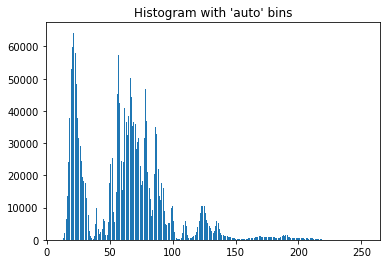

(34, 34)


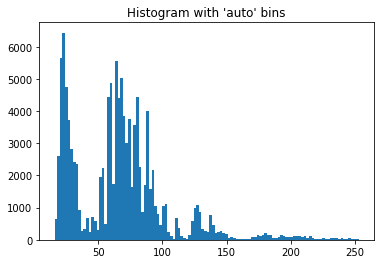

In [161]:
%matplotlib inline
for i in range(iters-1):
    if i == 0: continue
    layer = i
    print(have_roi_stacks[layer].shape[:2])
    plt.hist(have_roi_stacks[layer].flatten(), bins='auto')  # arguments are passed to np.histogram
    plt.title("Histogram with 'auto' bins")
    plt.show()


(143, 143)


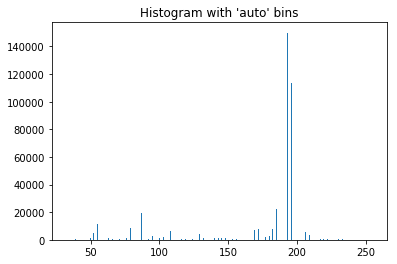

(34, 34)


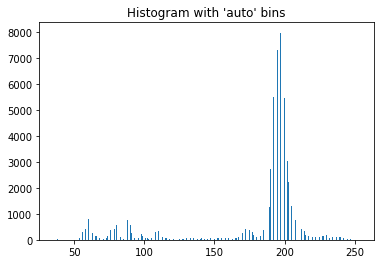

In [162]:
%matplotlib inline
for i in range(iters-1):
    if i == 0: continue
    layer = i
    print(no_roi_stacks[layer].shape[:2])
    plt.hist(no_roi_stacks[layer].flatten(), bins='auto')  # arguments are passed to np.histogram
    plt.title("Histogram with 'auto' bins")
    plt.show()